# 多维异常检测算法仿真（算法实践）

## 1、数据采集

> 读取 CPU\磁盘读\磁盘写\网络出口\网络入口\内存等监控指标，数据来源：广西科大数据（2017.1-2017.2）

In [1]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', figsize=(15, 6))
from dateutil.parser import parse
from sklearn.metrics import r2_score

In [2]:
vCpuUsage = pd.read_excel('../ECUST data/Guangxi university data 20170228/CPU_20170228171221.xlsx',converters={u'时间':parse})
vDiskRead = pd.read_excel('../ECUST data/Guangxi university data 20170228/DiskRead_20170228171404.xlsx',converters={u'时间':parse})
vDiskWrite = pd.read_excel('../ECUST data/Guangxi university data 20170228/DiskWrite_20170228171432.xlsx',converters={u'时间':parse})
vNwEgress = pd.read_excel('../ECUST data/Guangxi university data 20170228/NwEgress_20170228171526.xlsx',converters={u'时间':parse})
vNwIngress = pd.read_excel('../ECUST data/Guangxi university data 20170228/NwIngress_20170228171623.xlsx',converters={u'时间':parse})
vMemUsage = pd.read_excel('../ECUST data/Guangxi university data 20170228/Memory_20170228171333.xlsx',converters={u'时间':parse})

## 2.数据预处理

In [3]:
### 2.1、修改index和columns
for var in (vCpuUsage,vDiskRead,vDiskWrite,vNwEgress,vNwIngress,vMemUsage):
    var.rename(columns={u'资源':'vres',u'类型':'vtype',u'时间':'vtime',u'最大值':'vmax',u'最小值':'vmin',u'平均值':'vavg',u'单位':'vunit'},
               inplace = True)
    if 'vtime' in var.columns.values:
        var.set_index('vtime',inplace=True) 

### 2.2、初步探索时间序列数据,形成待分析多维数据矩阵X
for var in (vCpuUsage,vDiskRead,vDiskWrite,vNwEgress,vNwIngress,vMemUsage):
    print(var.head())
    print('length :',len(var))

X = pd.concat([vCpuUsage.to_period('Min').vavg,
               vDiskRead.to_period('Min').vavg,
               vDiskWrite.to_period('Min').vavg,
               vNwEgress.to_period('Min').vavg,
               vNwIngress.to_period('Min').vavg,
               vMemUsage.to_period('Min').vavg],axis=1,keys=['vCpuUsage','vDiskRead','vDiskWrite','vNwEgress','vNwIngress','vMemUsage'])

### 2.3、对缺失数据进行插值处理
#设定初始值后，对NaN进行线性插值
X.ix[0,X.ix[0].isnull()]=0
X.interpolate(method='time',inplace=True)

### 2.4、对CPU 0值数据进行填充
for i in range(1,len(X.vCpuUsage)):
    if X.vCpuUsage[i]==0:
        X.vCpuUsage[i] = X.vCpuUsage[i-1] 

#保留原始值
X_Original=X
X.describe()

### 2.5、无量纲化
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

X = DataFrame(MinMaxScaler().fit_transform(X_Original),index=X_Original.index,columns=X_Original.columns)

#区间缩放后再将均值0化，这主要是由于部分算法会自行对均值进行处理（比如pca的transform），为避免算法理解上的干扰，调整均值为0
X_mean=X.mean()
X_std=X.std()
X = X-X_mean

## 3、PCA降维分析

In [13]:
from sklearn.decomposition import PCA
import numpy.linalg as nlg

### 3.1、PCA数据探索
X_pca=PCA().fit(X)

### 3.2、确定主成分个数
#指定主成分的方差和所占的最小比例阈值为0.85
X_pca=PCA(n_components=0.85).fit(X)

## 4、ICA独立元分析方法的异常检测应用

In [17]:
### 4.1、ICA
from sklearn.decomposition import FastICA

X_ica=FastICA(n_components=X_pca.n_components_).fit(X)
X_S_=X_ica.transform(X)

#各种算法的变量统一，便于后续计算
X_ica_mixing_=X_ica.mixing_
X_ica_mean_=X_ica.mean_

X_ica_recover=DataFrame(np.dot(X_S_,X_ica_mixing_.T)+X_ica_mean_,index=X.index,columns=X.columns)

### 4.2、构造T2和SPE统计量
#计算T2统计量
X_ica_T2=Series(np.sum(X_S_**2,axis=1),index=X.index)

#计算SPE统计量
X_ica_SPE=Series(np.sum((X-X_ica_recover)**2,axis=1),index=X.index)

### 4.3、采用KDE方法，利用置信度确定阈值
from scipy import stats

def my_kde_bandwidth(obj, fac=1./2):
    """We use Scott's Rule, multiplied by a constant factor."""
    return np.power(obj.n, -1./(obj.d+4)) * fac

X_ica_T2_scipy_kde=stats.gaussian_kde(X_ica_T2, bw_method=my_kde_bandwidth)
X_ica_SPE_scipy_kde=stats.gaussian_kde(X_ica_SPE, bw_method=my_kde_bandwidth)

def get_threshold_of_scipy_kde(kde,start,step=1,confidence=0.997):
    """get threshold by confidence"""
    i = start
    cumsum = kde.integrate_box_1d(-np.inf, start)
    while True:
        if cumsum >= confidence:
            break
        cumsum = cumsum + kde.integrate_box_1d(i, i+step)
        i = i + step
        
    return i

# 通过概率密度函数求解概率时的累加步长设置(中位数与最大值距离100步)
X_ica_T2_pdf_step=(X_ica_T2.max()-X_ica_T2.median())/100
X_ica_SPE_pdf_step=(X_ica_SPE.max()-X_ica_SPE.median())/100

X_ica_T2_threshold=get_threshold_of_scipy_kde(X_ica_T2_scipy_kde,X_ica_T2.min(),step=X_ica_T2_pdf_step,confidence=0.997)
X_ica_SPE_threshold=get_threshold_of_scipy_kde(X_ica_SPE_scipy_kde,X_ica_SPE.min(),step=X_ica_SPE_pdf_step,confidence=0.997)

### 4.4、检测到的异常时刻

#### 4.4.1、T2检测
X_ica_T2_anomaly=X_ica_T2[X_ica_T2>X_ica_T2_threshold].index
#10min聚合，注意第一个元素的处理
indice=pd.Series([True]+list(np.diff(X_ica_T2_anomaly)>10))

X_ica_T2_anomaly_start=X_ica_T2_anomaly[indice].tolist()
X_ica_T2_anomaly_end=X_ica_T2_anomaly[indice.shift(-1).fillna(False)].tolist()
X_ica_T2_anomaly_end.append(X_ica_T2_anomaly[-1])

print('anomal periods detected by T2 metric are: ')
for each in zip(X_ica_T2_anomaly_start,X_ica_T2_anomaly_end):    
    print(each)

#### 4.4.2、SPE检测
X_ica_SPE_anomaly=X_ica_SPE[X_ica_SPE>X_ica_SPE_threshold].index
indice=pd.Series([True]+list(np.diff(X_ica_SPE_anomaly)>10))

X_ica_SPE_anomaly_start=X_ica_SPE_anomaly[indice].tolist()
X_ica_SPE_anomaly_end=X_ica_SPE_anomaly[indice.shift(-1).fillna(False)].tolist()
X_ica_SPE_anomaly_end.append(X_ica_SPE_anomaly[-1])

print('anomal periods detected by SPE metric are: ')
for each in zip(X_ica_SPE_anomaly_start,X_ica_SPE_anomaly_end):
    print(each)

## 5、相关性变化分析方法的异常检测应用

### 4.1、形成待分析的相关性矩阵

In [37]:
# DataFrame X(n*m),n:sample;m:dimention
def get_multiindex(X):
    dim=int(X.shape[1]*(X.shape[1]-1)/2)
    multiindex=[0]*dim
    count=0
    for j in range(X.shape[1]):
        for k in range(j+1,X.shape[1]):
            multiindex[count]=(X.columns[j],X.columns[k])
            count=count+1
    return multiindex

#默认窗口win个点，每次移动的步长是step，重叠部分为win-step
def get_X_cov_values_by_win(X,win,step):
    irow=int(X.shape[0]/step)
    if X.shape[0]-irow*step>0:
        irow=irow+1
    icolumn=int(X.shape[1]*(X.shape[1]-1)/2)    
    X_cov_values = np.empty([irow, icolumn])
    
    for i in range(irow):    
        istep=i*step
        X_win=X[istep:istep+win] if (istep+win)<X.shape[0] else X[i:]
        
        X_win_cov=X_win.cov().fillna(0)
        count=0
        for j in range(len(X_win_cov)):
            for k in range(j+1,len(X_win_cov)):
                X_cov_values[i,count]=X_win_cov.ix[j,k]
                count=count+1    
    
    return X_cov_values            

#形成相关性矩阵
win=100
step=60
X_win_cov_values = get_X_cov_values_by_win(X,win,step)
X_win_cov_multiindex_1,X_win_cov_multiindex_2=zip(*get_multiindex(X))
X_win_cov=DataFrame(X_win_cov_values,index=X.index[::step],columns=[list(X_win_cov_multiindex_1),list(X_win_cov_multiindex_2)]) 
X_win_cov.head()

vCpuUsage                                               \
                     vDiskRead vDiskWrite vNwEgress    vNwIngress vMemUsage   
vtime                                                                         
2017-01-01 00:00  7.011061e-05   0.000383 -0.000131 -8.040564e-05  0.001328   
2017-01-01 01:00  1.753272e-04   0.000542  0.000007 -2.366871e-05 -0.002395   
2017-01-01 02:00  1.825234e-04   0.000746  0.000202  7.149853e-05  0.000920   
2017-01-01 03:02  1.337451e-36  -0.000014 -0.000014 -2.779798e-08  0.000200   
2017-01-01 04:04 -3.282835e-36  -0.000027  0.000023  1.958872e-05  0.000240   

                     vDiskRead                                            \
                    vDiskWrite     vNwEgress    vNwIngress     vMemUsage   
vtime                                                                      
2017-01-01 00:00  1.138929e-07  5.367667e-07  1.245805e-07  6.818070e-06   
2017-01-01 01:00  2.725698e-06 -1.348812e-07 -1.063438e-07 -5.745543e-06   
2017-01-01 02:00  3.947693e-06  1.840476e-07  4.519830e-08  3.972411e-07   
2017-01-01 03:02 -2.659704e-38 -4.331519e-37 -1.671814e-37  5.775358e-37   
2017-01-01 04:04  9.498944e-39  1.519831e-38 -4.559493e-37 -6.079324e-38   

                    vDiskWrite                                 vNwEgress  \
                     vNwEgress    vNwIngress     vMemUsage    vNwIngress   
vtime                                                                      
2017-01-01 00:00  9.238757e-07  5.737410e-07 -2.676613e-05  1.930543e-06   
2017-01-01 01:00 -1.201900e-06 -4.701954e-07 -2.474204e-05  4.637962e-07   
2017-01-01 02:00  6.252158e-07  3.061133e-07  2.904819e-06  2.246766e-07   
2017-01-01 03:02  1.296040e-07  5.751788e-08  9.162840e-08  1.276061e-07   
2017-01-01 04:04  1.730693e-07  4.844790e-08  2.681770e-07  4.316578e-08   

                                  vNwIngress  
                     vMemUsage     vMemUsage  
vtime                                         
2017-01-01 00:00  4.027917e-05  9.625987e-06  
2017-01-01 01:00  8.014652e-06  2.587749e-06  
2017-01-01 02:00  1.267001e-06  4.473813e-07  
2017-01-01 03:02  4.372578e-08  7.923193e-09  
2017-01-01 04:04  2.175536e-07  8.163219e-08

### 4.2、PCA

anomal periods detected by T2 metric are: 
(Period('2017-01-18 09:04', 'T'), Period('2017-01-18 10:44', 'T'))
(Period('2017-01-21 14:13', 'T'), Period('2017-01-21 15:53', 'T'))
(Period('2017-02-15 14:43', 'T'), Period('2017-02-15 16:23', 'T'))
anomal periods detected by SPE metric are: 
(Period('2017-01-15 09:52', 'T'), Period('2017-01-15 11:32', 'T'))
(Period('2017-01-15 10:58', 'T'), Period('2017-01-15 12:38', 'T'))
(Period('2017-01-16 09:24', 'T'), Period('2017-01-16 11:04', 'T'))
(Period('2017-01-16 10:29', 'T'), Period('2017-01-16 12:09', 'T'))


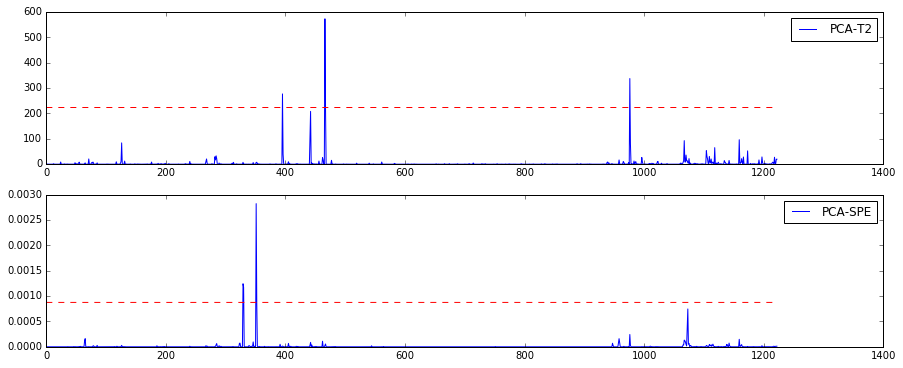

In [38]:
X_win_cov_pca=PCA(n_components=0.85).fit(X_win_cov)
X_win_cov_pca_recover=DataFrame(np.dot(X_win_cov,np.dot(X_win_cov_pca.components_.T,X_win_cov_pca.components_)),
                                index=X_win_cov.index,columns=X_win_cov.columns)

#计算T2统计量
X_win_cov_pca_T2=Series([np.dot(np.dot(np.dot(np.dot(X_win_cov.ix[i].T,X_win_cov_pca.components_.T),
                                              nlg.inv(np.diag(X_win_cov_pca.explained_variance_))),X_win_cov_pca.components_),X_win_cov.ix[i]) 
                         for i in np.arange(len(X_win_cov))],index=X_win_cov.index)
#计算SPE统计量
X_win_cov_pca_SPE=Series(np.sum((X_win_cov-X_win_cov_pca_recover)**2,axis=1),index=X_win_cov.index)

# 通过概率密度函数求解概率时的累加步长设置(中位数与最大值距离100步)
X_win_cov_pca_T2_pdf_step=(X_win_cov_pca_T2.max()-X_win_cov_pca_T2.median())/100
X_win_cov_pca_SPE_pdf_step=(X_win_cov_pca_SPE.max()-X_win_cov_pca_SPE.median())/100

#kde及阈值估计
X_win_cov_pca_T2_scipy_kde=stats.gaussian_kde(X_win_cov_pca_T2, bw_method=my_kde_bandwidth)
X_win_cov_pca_SPE_scipy_kde=stats.gaussian_kde(X_win_cov_pca_SPE, bw_method=my_kde_bandwidth)
X_win_cov_pca_T2_threshold=get_threshold_of_scipy_kde(X_win_cov_pca_T2_scipy_kde,X_win_cov_pca_T2.min(),step=X_win_cov_pca_T2_pdf_step,confidence=0.997)
X_win_cov_pca_SPE_threshold=get_threshold_of_scipy_kde(X_win_cov_pca_SPE_scipy_kde,X_win_cov_pca_SPE.min(),step=X_win_cov_pca_SPE_pdf_step,confidence=0.997)

#绘图
plt.subplot(211)
plt.plot(X_win_cov_pca_T2.values,label='PCA-T2')
plt.plot(X_win_cov_pca_T2_threshold*np.ones(len(X_win_cov_pca_T2)),'r--')
plt.legend(loc='best')
plt.subplot(212)
plt.plot(X_win_cov_pca_SPE.values,label='PCA-SPE')
plt.plot(X_win_cov_pca_SPE_threshold*np.ones(len(X_win_cov_pca_SPE)),'r--')
plt.legend(loc='best')

#输出异常时间段
X_win_cov_pca_T2_anomaly=X_win_cov_pca_T2[X_win_cov_pca_T2>X_win_cov_pca_T2_threshold].index
print('anomal periods detected by T2 metric are: ')
for each in zip(X_win_cov_pca_T2_anomaly,X_win_cov_pca_T2_anomaly+win):
    print(each)
print('anomal periods detected by SPE metric are: ')
X_win_cov_pca_SPE_anomaly=X_win_cov_pca_SPE[X_win_cov_pca_SPE>X_win_cov_pca_SPE_threshold].index
for each in zip(X_win_cov_pca_SPE_anomaly,X_win_cov_pca_SPE_anomaly+win):
    print(each)

### 4.2、ICA

anomal periods detected by T2 metric are: 
(Period('2017-01-18 09:04', 'T'), Period('2017-01-18 10:44', 'T'))
(Period('2017-01-21 14:13', 'T'), Period('2017-01-21 15:53', 'T'))
(Period('2017-01-21 15:18', 'T'), Period('2017-01-21 16:58', 'T'))
anomal periods detected by SPE metric are: 
(Period('2017-01-15 09:52', 'T'), Period('2017-01-15 11:32', 'T'))
(Period('2017-01-15 10:58', 'T'), Period('2017-01-15 12:38', 'T'))
(Period('2017-01-16 09:24', 'T'), Period('2017-01-16 11:04', 'T'))
(Period('2017-02-15 14:43', 'T'), Period('2017-02-15 16:23', 'T'))


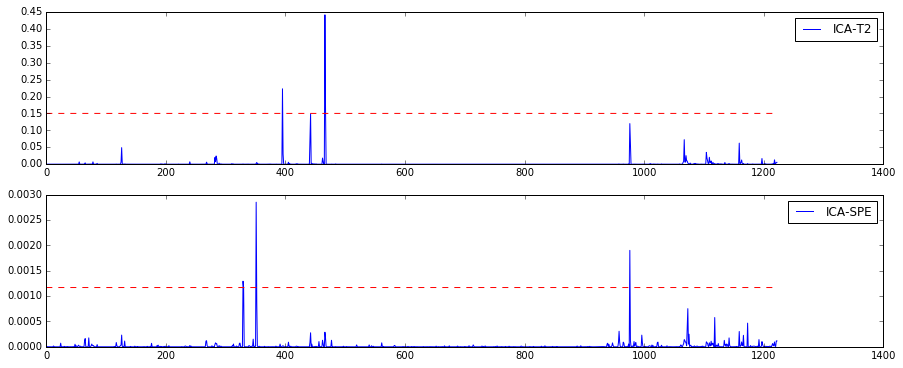

In [39]:
n=X_pca.n_components_
X_win_cov_ica=FastICA(n_components=n).fit(X_win_cov)
X_win_cov_S_=X_win_cov_ica.transform(X_win_cov)
X_win_cov_ica_recover=DataFrame(np.dot(X_win_cov_S_,X_win_cov_ica.mixing_.T)+X_win_cov_ica.mean_,
                                index=X_win_cov.index,columns=X_win_cov.columns)

#计算T2统计量
X_win_cov_ica_T2=Series(np.sum(X_win_cov_S_**2,axis=1),index=X_win_cov.index)
#计算SPE统计量
X_win_cov_ica_SPE=Series(np.sum((X_win_cov-X_win_cov_ica_recover)**2,axis=1),index=X_win_cov.index)

# 通过概率密度函数求解概率时的累加步长设置(中位数与最大值距离100步)
X_win_cov_ica_T2_pdf_step=(X_win_cov_ica_T2.max()-X_win_cov_ica_T2.median())/100
X_win_cov_ica_SPE_pdf_step=(X_win_cov_ica_SPE.max()-X_win_cov_ica_SPE.median())/100

#kde及阈值估计
X_win_cov_ica_T2_scipy_kde=stats.gaussian_kde(X_win_cov_ica_T2, bw_method=my_kde_bandwidth)
X_win_cov_ica_SPE_scipy_kde=stats.gaussian_kde(X_win_cov_ica_SPE, bw_method=my_kde_bandwidth)
X_win_cov_ica_T2_threshold=get_threshold_of_scipy_kde(X_win_cov_ica_T2_scipy_kde,X_win_cov_ica_T2.min(),step=X_win_cov_ica_T2_pdf_step,confidence=0.997)
X_win_cov_ica_SPE_threshold=get_threshold_of_scipy_kde(X_win_cov_ica_SPE_scipy_kde,X_win_cov_ica_SPE.min(),step=X_win_cov_ica_SPE_pdf_step,confidence=0.997)

#绘图
plt.subplot(211)
plt.plot(X_win_cov_ica_T2.values,label='ICA-T2')
plt.plot(X_win_cov_ica_T2_threshold*np.ones(len(X_win_cov_ica_T2)),'r--')
plt.legend(loc='best')
plt.subplot(212)
plt.plot(X_win_cov_ica_SPE.values,label='ICA-SPE')
plt.plot(X_win_cov_ica_SPE_threshold*np.ones(len(X_win_cov_ica_SPE)),'r--')
plt.legend(loc='best')

#输出异常时间段
X_win_cov_ica_T2_anomaly=X_win_cov_ica_T2[X_win_cov_ica_T2>X_win_cov_ica_T2_threshold].index
print('anomal periods detected by T2 metric are: ')
for each in zip(X_win_cov_ica_T2_anomaly,X_win_cov_ica_T2_anomaly+win):
    print(each)
print('anomal periods detected by SPE metric are: ')
X_win_cov_ica_SPE_anomaly=X_win_cov_ica_SPE[X_win_cov_ica_SPE>X_win_cov_ica_SPE_threshold].index
for each in zip(X_win_cov_ica_SPE_anomaly,X_win_cov_ica_SPE_anomaly+win):
    print(each)